In [5]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Self-Driving Cars/State Estimation and Localization/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd /content/drive/My\ Drive/$FOLDERNAME/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Self-Driving Cars/State Estimation and Localization


In [6]:
# Starter code for the Coursera SDC Course 2 final project.
#
# Author: Trevor Ablett and Jonathan Kelly
# University of Toronto Institute for Aerospace Studies
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion
from numpy.linalg import inv

## Part 1

### Data setup and visualization

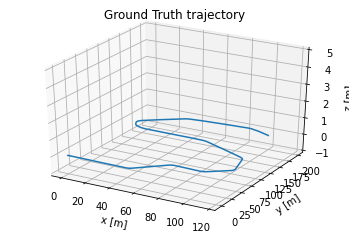

In [131]:
# pt.1 & pt.2
with open('data/pt1_data.pkl', 'rb') as file:
    data = pickle.load(file)

################################################################################################
# Each element of the data dictionary is stored as an item from the data dictionary,
# will be stored in local variables, described by the following:
#   gt: Data object containing ground truth. with the following fields:
#     a: Acceleration of the vehicle, in the inertial frame
#     v: Velocity of the vehicle, in the inertial frame
#     p: Position of the vehicle, in the inertial frame
#     alpha: Rotational acceleration of the vehicle, in the inertial frame
#     w: Rotational velocity of the vehicle, in the inertial frame
#     r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
#     _t: Timestamp in ms.
#   imu_f: StampedData object with the imu specific force data (given in vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   gnss: StampedData object with the GNSS data.
#     data: The actual data
#     t: Timestamps in ms.
#   lidar: StampedData object with the LIDAR data (positions only).
#     data: The actual data
#     t: Timestamps in ms.
################################################################################################

gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

################################################################################################
# Plot the ground truth trajectory to see what it looks like
################################################################################################

gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

In [132]:
################################################################################################
# Remember that our LIDAR data is actually just a set of positions estimated from a separate
# scan-matching system, so we can insert it into our solver as another position measurement,
# just as we do for GNSS. However, the LIDAR frame is not the same as the frame shared by the
# IMU and the GNSS. To remedy this, we transform the LIDAR data to the IMU frame using our 
# known extrinsic calibration rotation matrix C_li and translation vector t_i_li.
################################################################################################

# Correct calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.1).
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

### Parameters and constants

In [133]:
################################################################################################
# One of the most important aspects of a filter is setting the estimated sensor variances correctly.
# We set the values here.
################################################################################################

# pt.1 (Origin)
var_imu_f = 0.10
var_imu_w = 0.25
var_gnss  = 0.01
var_lidar = 1.00

In [134]:
################################################################################################
# We can also set up some constants that won't change for any iteration of our solver.
################################################################################################

g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

### ES-EKF

Initial Values

In [135]:
################################################################################################
# Initial values for our ES-EKF solver.
################################################################################################

p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0

#### Measurement Update

In [136]:
################################################################################################
# Measurement update for both the GNSS and the LIDAR data              
################################################################################################

def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    R = sensor_var * np.eye(3) # notice here is * but not @ operation!
    # because h_jac is 3x9, so h_jac @ p_cov_check @ h_jac.T is 3x3
    # so R is 3x3

    # 3.1 Compute Kalman Gain
    k_k = p_cov_check @ h_jac.T @ inv(h_jac @ p_cov_check @ h_jac.T + R)

    # 3.2 Compute error state
    delta_x_k = k_k @ (y_k - p_check)

    # 3.3 Correct predicted state
    delta_p_k = delta_x_k[:3]
    delta_v_k = delta_x_k[3:6]
    delta_q_k = delta_x_k[6:]

    p_hat = p_check + delta_p_k
    v_hat = v_check + delta_v_k
    q_hat = Quaternion(axis_angle=delta_q_k).quat_mult_left(q_check)

    # 3.4 Compute corrected covariance
    p_cov_hat = (np.eye(9) - k_k @ h_jac) @ p_cov_check
    # print((k_k @ h_jac).shape) 9x9

    return p_hat, v_hat, q_hat, p_cov_hat

#### Main Filter Loop

In [137]:
def filter_loop(p_est, v_est, q_est, p_cov):
  gnss_i  = 0
  lidar_i = 0
  for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    C_ns = Quaternion(*q_est[k - 1]).to_mat()

    # 1. Update state with IMU inputs
    p_est[k] = p_est[k - 1] + delta_t * v_est[k - 1] + (delta_t ** 2 / 2) * (C_ns @ imu_f.data[k - 1] + g)
    v_est[k] = v_est[k - 1] + delta_t * (C_ns @ imu_f.data[k - 1] + g)
    q_est[k] = Quaternion(axis_angle=imu_w.data[k - 1] * delta_t).quat_mult_right(q_est[k - 1])

    # 1.1 Linearize the motion model and compute Jacobians
    F = np.eye(9)
    Q = np.eye(6)

    F[:3, 3:6] = np.eye(3) * delta_t
    F[3:6, 6:] = -skew_symmetric(C_ns @ imu_f.data[k - 1]) * delta_t

    Q[:3, :3] *= delta_t ** 2 * var_imu_f
    Q[3:, 3:] *= delta_t ** 2 * var_imu_w

    # 2. Propagate uncertainty
    p_cov[k] = F @ p_cov[k - 1] @ F.T + l_jac @ Q @ l_jac.T

    # 3. Check availability of GNSS and LIDAR measurements
    if gnss_i < gnss.t.shape[0] and imu_f.t[k] >= gnss.t[gnss_i]:
      p_est[k], v_est[k], q_est[k], p_cov[k] = measurement_update(var_gnss, p_cov[k], gnss.data[gnss_i], p_est[k], v_est[k], q_est[k])
      gnss_i += 1

    if lidar_i < lidar.t.shape[0] and imu_f.t[k] >= lidar.t[lidar_i]:
      p_est[k], v_est[k], q_est[k], p_cov[k] = measurement_update(var_lidar, p_cov[k], lidar.data[lidar_i], p_est[k], v_est[k], q_est[k])
      lidar_i += 1
    # Update states (save)

  return p_est, v_est, q_est, p_cov

### Results and Analysis

#### Plotting utils

In [138]:
def plot_trajectory(p_est):
  est_traj_fig = plt.figure()
  ax = est_traj_fig.add_subplot(111, projection='3d')
  ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
  ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
  ax.set_xlabel('Easting [m]')
  ax.set_ylabel('Northing [m]')
  ax.set_zlabel('Up [m]')
  ax.set_title('Ground Truth and Estimated Trajectory')
  ax.set_xlim(0, 200)
  ax.set_ylim(0, 200)
  ax.set_zlim(-2, 2)
  ax.set_xticks([0, 50, 100, 150, 200])
  ax.set_yticks([0, 50, 100, 150, 200])
  ax.set_zticks([-2, -1, 0, 1, 2])
  ax.legend(loc=(0.62,0.77))
  ax.view_init(elev=45, azim=-50)
  plt.show()

def plot_errors(p_est, v_est, q_est):
  error_fig, ax = plt.subplots(2, 3)
  error_fig.suptitle('Error Plots')
  num_gt = gt.p.shape[0]
  p_est_euler = []
  p_cov_euler_std = []

  # Convert estimated quaternions to euler angles
  for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

  p_est_euler = np.array(p_est_euler)
  p_cov_euler_std = np.array(p_cov_euler_std)

  # Get uncertainty estimates from P matrix
  p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

  titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
  for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
  ax[0,0].set_ylabel('Meters')

  for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(gt.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
  ax[1,0].set_ylabel('Radians')
  plt.show()

#### Estimated Trajectory

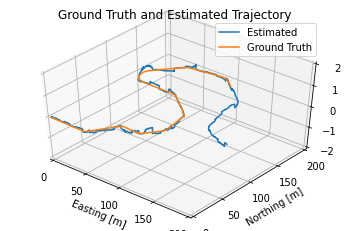

In [139]:
p_est, v_est, q_est, p_cov = filter_loop(p_est, v_est, q_est, p_cov)
plot_trajectory(p_est)

#### Error estimates

The error estimates are in blue, and the uncertainty bounds are red and dashed.
The uncertainty bounds are +/- 3 standard deviations based on the uncertainty (covariance).

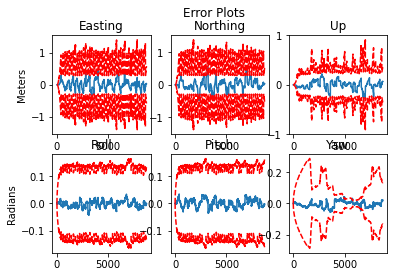

In [140]:
plot_errors(p_est, v_est, q_est)

## Part 2

Examine the effects of sensor miscalibration on the vehicle pose estimates. The transformation between the LIDAR sensor frame and the IMU sensor frame is intentionally altered; use of the incorrect transform will result in errors in the vehicle position estimates. The task is to determine how to adjust the filter parameters (noise variances) to attempt to compensate for these errors. The filter code remains unchanged.

In [142]:
# Incorrect calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.05).
C_li = np.array([
     [ 0.9975 , -0.04742,  0.05235],
     [ 0.04992,  0.99763, -0.04742],
     [-0.04998,  0.04992,  0.9975 ]
])

t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

Define a reset function for convience

In [143]:
def reset():
  p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
  v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
  q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
  p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

  p_est[0] = gt.p[0]
  v_est[0] = gt.v[0]
  q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
  p_cov[0] = np.zeros(9)  # covariance of estimate

  return p_est, v_est, q_est, p_cov

Use the original covariance parameters for estimation

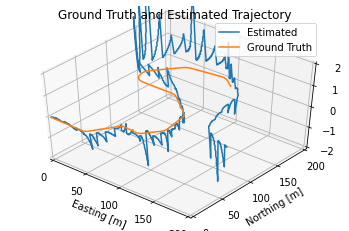

In [144]:
p_est, v_est, q_est, p_cov = reset()
p_est, v_est, q_est, p_cov = filter_loop(p_est, v_est, q_est, p_cov)
plot_trajectory(p_est)

The result is pretty bad.
We can improve it by tuning the covariance parameters.

In [145]:
var_imu_f = 0.1
var_imu_w = 0.002
var_gnss = 0.01
var_lidar = 30

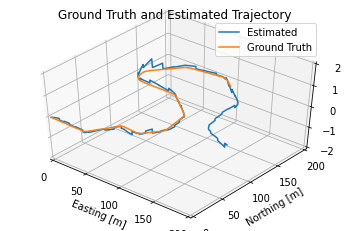

In [146]:
p_est, v_est, q_est, p_cov = reset()
p_est, v_est, q_est, p_cov = filter_loop(p_est, v_est, q_est, p_cov)
plot_trajectory(p_est)

The result is much better

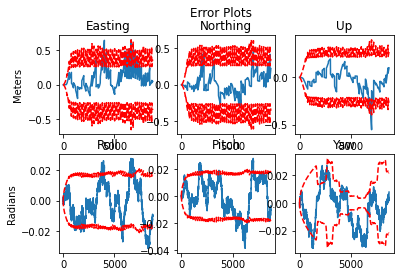

In [147]:
plot_errors(p_est, v_est, q_est)

And the errors are bounded most of the time

## Part 3

Explore the effects of sensor dropout, that is, when all external positioning information (from GPS and LIDAR) is lost for a short period of time. For Part 3, a different dataset is loaded where a portion of the GPS and LIDAR measurements are missing. The goal of Part 3 is to illustrate how the loss of external corrections results in drift in the vehicle position estimate, and also to aid in understanding how the uncertainty in the position estimate changes when sensor measurements are unavailable.

In [148]:
with open('data/pt3_data.pkl', 'rb') as file:
    data = pickle.load(file)
    
gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

In [149]:
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

Again examine the estimation use the orignal covariance parameters

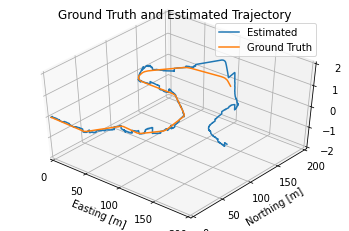

In [150]:
# Origin
var_imu_f = 0.10
var_imu_w = 0.25
var_gnss  = 0.01
var_lidar = 1.00

p_est, v_est, q_est, p_cov = reset()
p_est, v_est, q_est, p_cov = filter_loop(p_est, v_est, q_est, p_cov)
plot_trajectory(p_est)

Not too bad but the estimated trajectory diverges at the end

In [151]:
var_imu_f = 0.01
var_imu_w = 0.01
var_gnss  = 0.005
var_lidar = 1.00

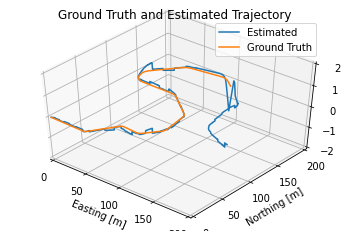

In [152]:
p_est, v_est, q_est, p_cov = reset()
p_est, v_est, q_est, p_cov = filter_loop(p_est, v_est, q_est, p_cov)
plot_trajectory(p_est)

compensate the originally diverged part, but the following part has a zig-zag, which is hard to avoid.

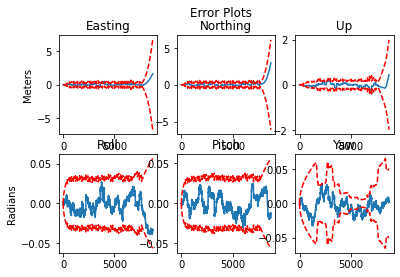

In [153]:
plot_errors(p_est, v_est, q_est)

The errors are also bounded most of the time